In [1]:
from importlib import reload
from matplotlib.axes import Axes
import packetPreprocessing, packetsHandler,testAndVerification
import decimal
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
import math
import random
import gc

from packetPreprocessing import *
from packetsHandler import *
import time


reload(packetsHandler)
reload(packetPreprocessing)
reload(testAndVerification)

<module 'testAndVerification' from '/home/zijun/Traffic-Simulation/script/testAndVerification.py'>

In [2]:

wirelens=getwirelen(readPcap('../dataset/equinix-nyc.dirA.20180315-130000.UTC.anon.pcap/'
                             'equinix-nyc.dirA.20180315-130000.UTC.anon.pcap'))

timestamps=readTimestamp("../dataset/equinix-nyc.dirA.20180315-130000.UTC.anon.times/"
                         "equinix-nyc.dirA.20180315-130000.UTC.anon.times")

# timestampsAndWirelens=list(zip(timestamps,wirelens))


In [3]:
timestampsAndWirelensPD=pd.DataFrame({
    'timestamp':timestamps,
    'wirelen':wirelens,              
    })
timestampsAndWirelensPD.to_csv("../dataset/timestampsAndWirelens.csv")

In [2]:
timestampsAndWirelensPD=pd.read_csv("timestampsAndWirelens",dtype={'timestamp':str})

In [44]:
i=0
for timestamp, wirelen in \
            zip(timestampsAndWirelensPD['timestamp'],timestampsAndWirelensPD['wirelen']):
    timestamp=Decimal(timestamp)
    print(timestamp,wirelen)
    i+=1
    if(i==20): break
    

1521118800.000005990 1504
1521118800.000007272 1504
1521118800.000008553 305
1521118800.000008814 1504
1521118800.000010096 1504
1521118800.000011377 1504
1521118800.000012651 1382
1521118800.000014342 120
1521118800.000014462 1504
1521118800.000015736 409
1521118800.000016116 1504
1521118800.000017382 1504
1521118800.000018656 1382
1521118800.000019841 1504
1521118800.000021115 56
1521118800.000021182 1504
1521118800.000022456 1504
1521118800.000023730 1504
1521118800.000025012 1504
1521118800.000026278 1504


In [3]:
# packNums1,timestamps1,byteSlots1, byteRates1=splitToTimeSlot(timestampsAndWirelensPD, 1)
# packNums0p1,timestamps0p1,byteSlots0p1, byteRates0p1=splitToTimeSlot(timestampsAndWirelensPD, 0.1)
# packNums0p01,timestamps0p01,byteSlots0p01, byteRates0p01=splitToTimeSlot(timestampsAndWirelensPD, 0.01)
packNums0p001,timestamps0p001,byteSlots0p001, byteRates0p001=splitToTimeSlot(timestampsAndWirelensPD, 0.001)


startTime: 1521118800.000005990
endThisSlot: 1521118800.001005990


In [62]:
len(byteRates1)

60

In [4]:
# pd.DataFrame(data={
#     'timestamp':timestamps1,
#     'byterate':byteRates1,
#     "packnum":  packNums1              
#     }).to_csv("../dataset/data_for_1s_time_slot.csv",index=False)

# pd.DataFrame(data={
#     'timestamp':timestamps0p1,
#     'byterate':byteRates0p1,
#     "packnum":  packNums0p1              
#        }).to_csv("../dataset/data_for_0p1s_time_slot.csv",index=False)
# 
# 
# pd.DataFrame({
#     'timestamp':timestamps0p01,
#     'byterate':byteRates0p01,
#     "packnum":  packNums0p01              
#     }).to_csv("../dataset/data_for_0p01s_time_slot.csv",index=False)

pd.DataFrame({
    'timestamp':timestamps0p001,
    'byterate':byteRates0p001,
    "packnum":  packNums0p001              
    }).to_csv("../dataset/data_for_0p001s_time_slot.csv",index=False)

In [7]:
data_prefix='../dataset/'
data001 = pd.read_csv(data_prefix+"data_for_0p01s_time_slot.csv",index_col=0)
data01 = pd.read_csv(data_prefix+"data_for_0p1s_time_slot.csv",index_col=0)
data1 = pd.read_csv(data_prefix+"data_for_1s_time_slot.csv",index_col=0)                    
data10 = pd.read_csv(data_prefix+"data_for_10s_time_slot.csv",index_col=0)  


 1_ARIMA.ipynb			 packetPreprocessing.py
 2_ARIMA.ipynb			 packetsHandler.py
'ARIMA model results.pdf'	 pred_train
 ARIMA_test.ipynb		 __pycache__
 autocorrelation_plot_0p1s.png	 test2.ipynb
 FFT_DWT_test.ipynb		 testAndVerification.py
 fractional_differencing.py	 test.ipynb
 main.ipynb			 Untitled.ipynb
 main.py			 预测.ipynb
'New Text Document.txt'


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2f0e387cf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f0e36c4a8>)

<Figure size 432x288 with 0 Axes>

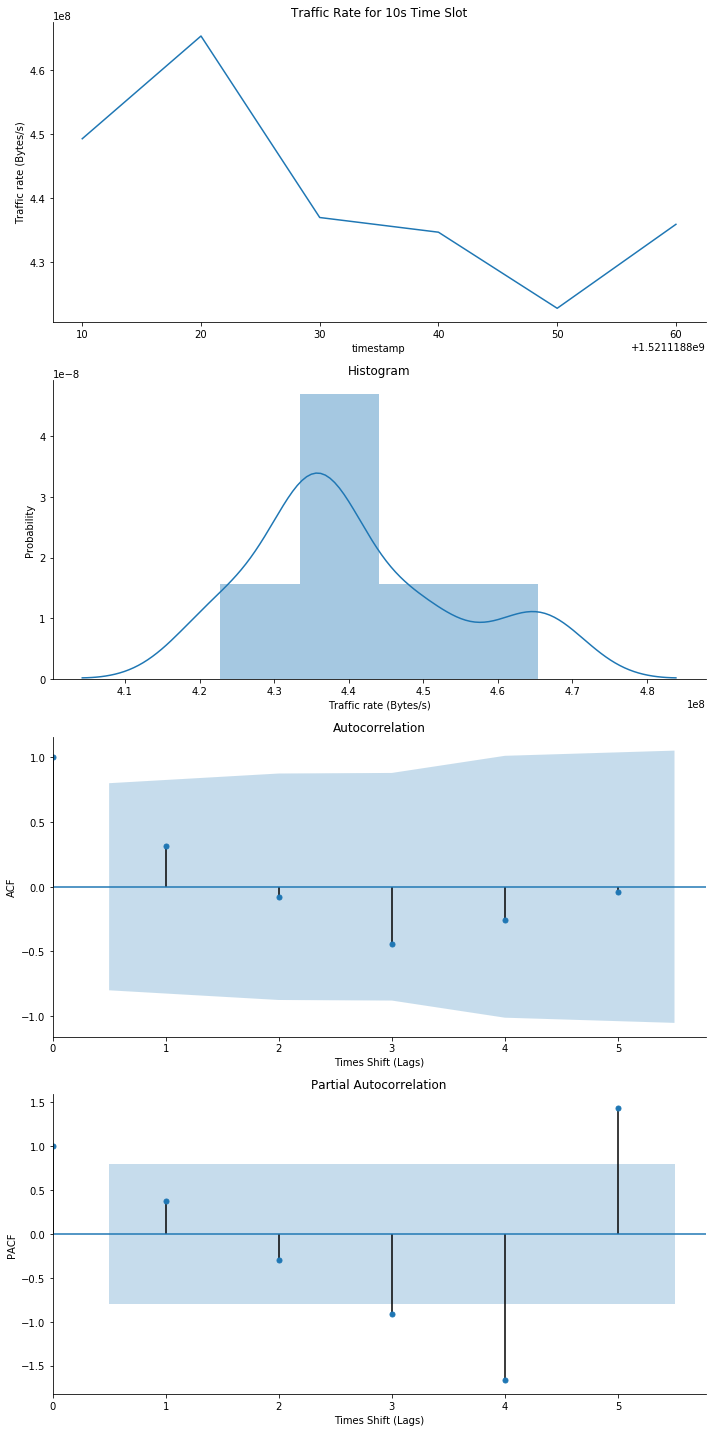

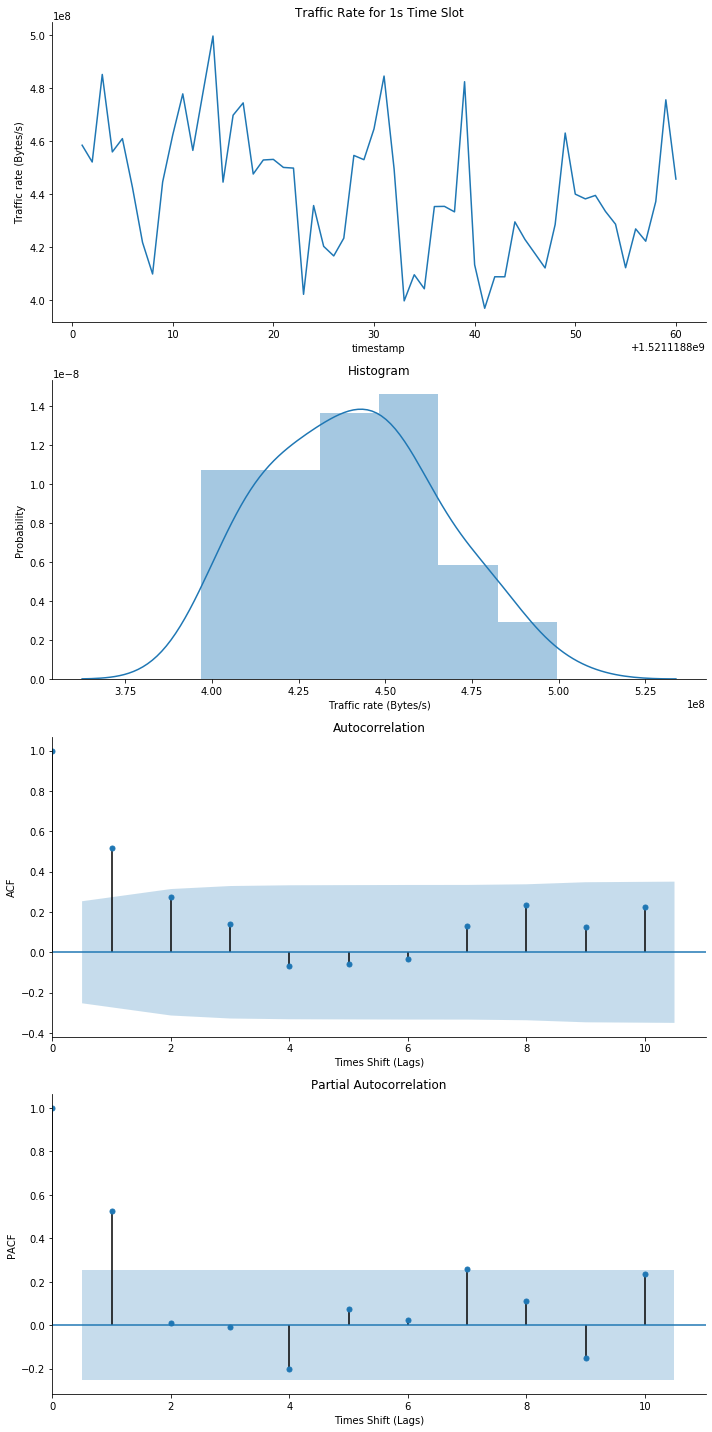

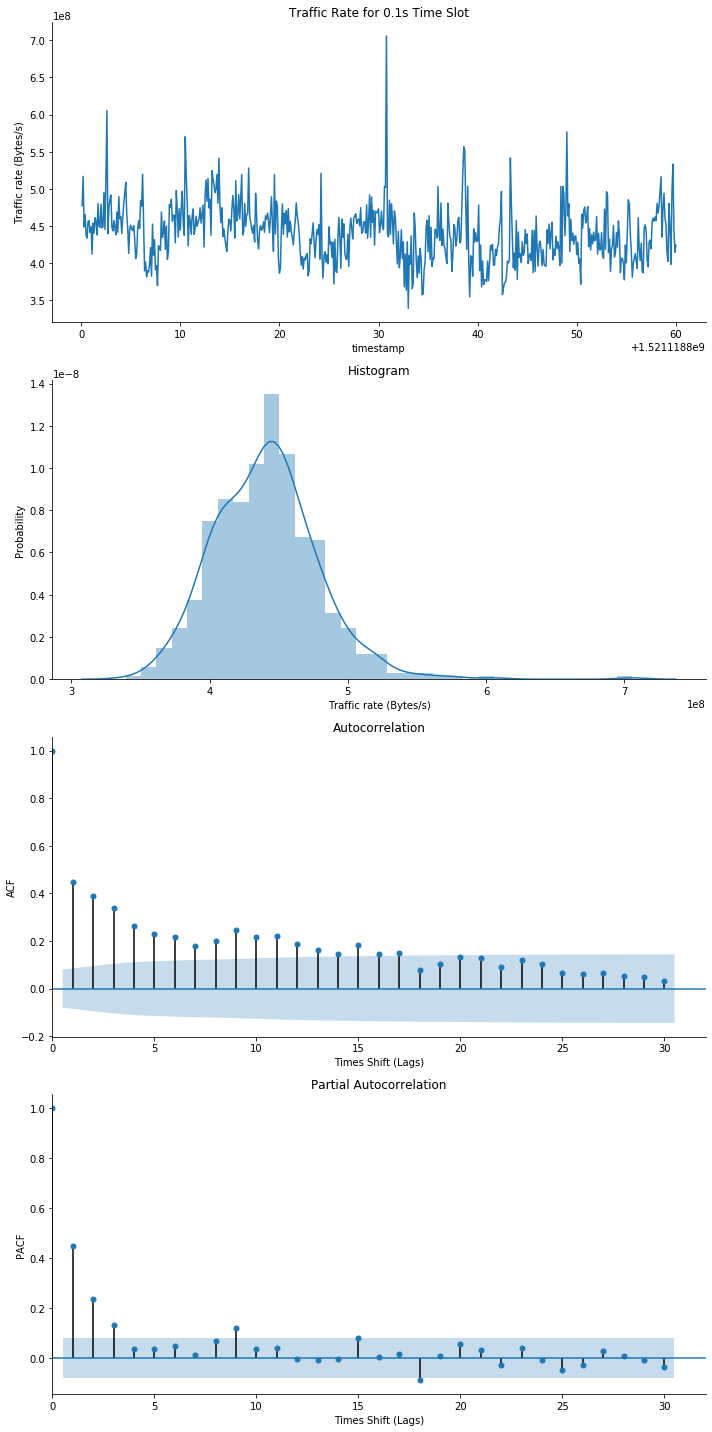

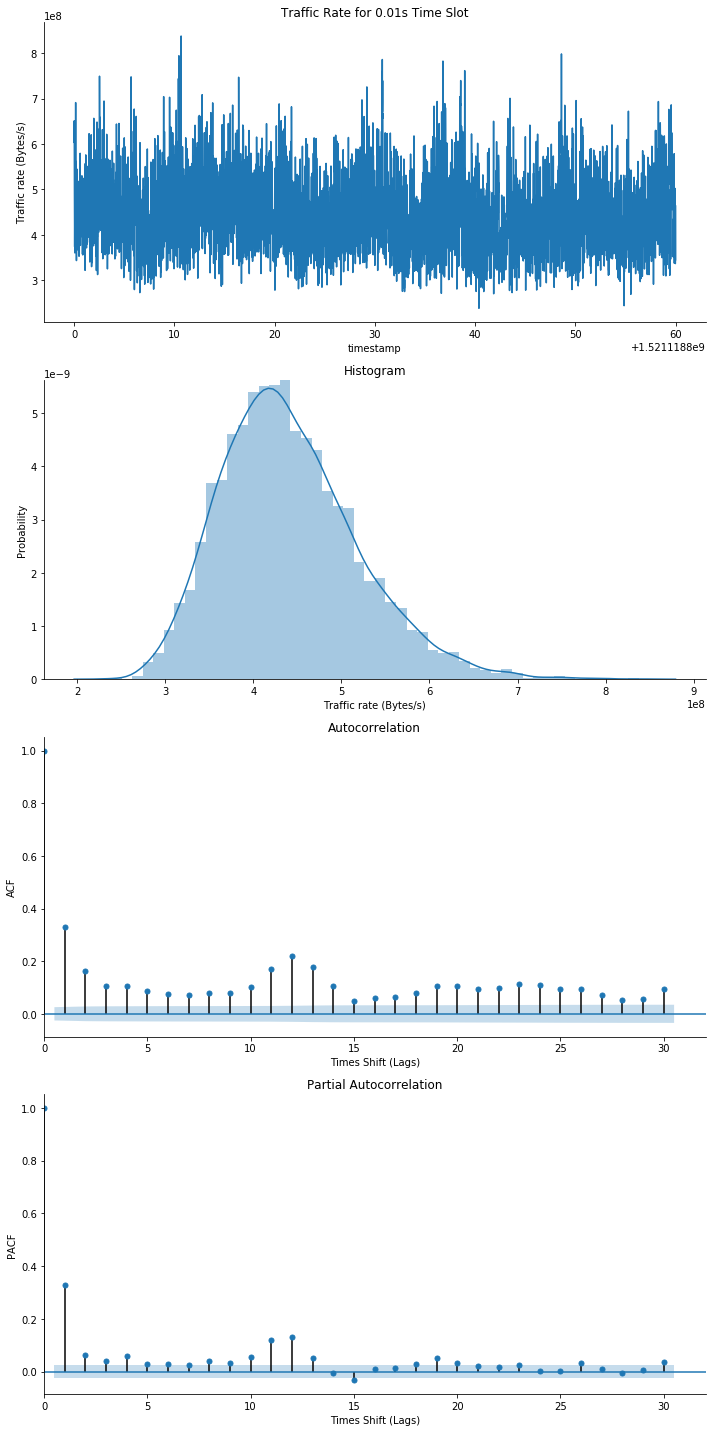

In [8]:
plt.cla() # 清除axes，即当前 figure 中的活动的axes，但其他axes保持不变。
plt.clf() 
from testAndVerification import *
reload(testAndVerification)
tsplot(data1["byterate"], lags=10,title="Traffic Rate for 1s Time Slot")
tsplot(data01["byterate"], lags=30,title="Traffic Rate for 0.1s Time Slot")
tsplot(data001["byterate"], lags=30,title="Traffic Rate for 0.01s Time Slot")
tsplot(data0001["byterate"], lags=10,title="Traffic Rate for 1s Time Slot")



In [22]:
len(data10)

6

In [10]:
import testAndVerification
reload(testAndVerification)
plt.cla() # 清除axes，即当前 figure 中的活动的axes，但其他axes保持不变。
plt.clf()
plt.close()
plot_diff_timescales(data10["byterate"],
                     data1["byterate"],
                     data01["byterate"],
                     data001["byterate"],
                    )






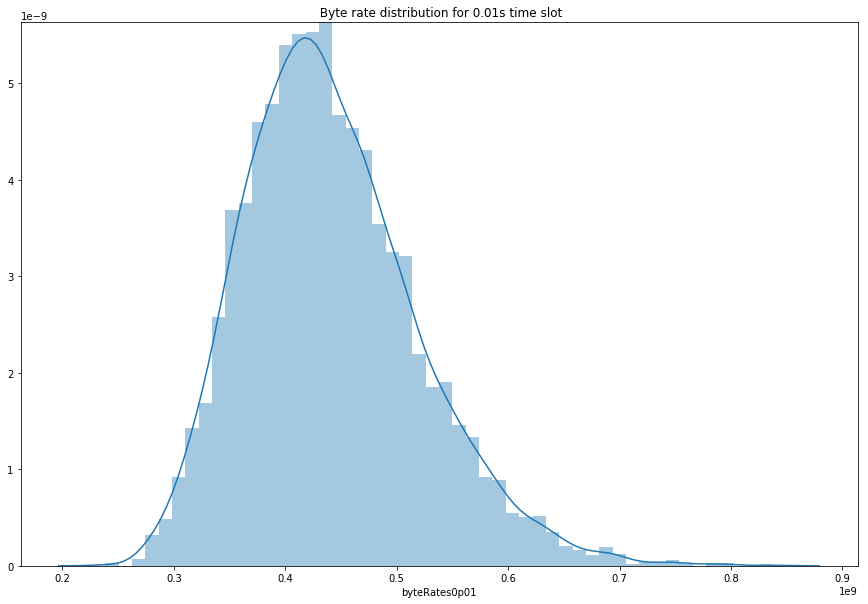

In [6]:
distfig=sns.distplot(data001["byteRates0p01"])
distfig.set_title(" Byte rate distribution for 0.01s time slot")
distfig.get_figure().set_size_inches(15,10)
distfig.get_figure().savefig("dist_plot_0p01s_time_slot")

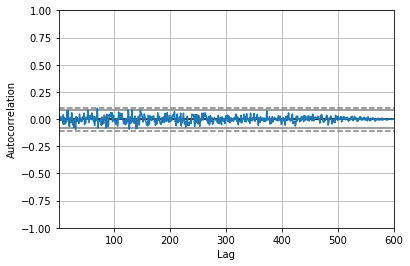

In [10]:


pd.plotting.autocorrelation_plot([random.random() for x in range(600) ])

In [ ]:
"""
Python code for fractional differencing of pandas time series
illustrating the concepts of the article "Preserving Memory in Stationary Time Series" 
by Simon Kuttruf

While this code is dedicated to the public domain for use without permission, the author disclaims any liability in connection with the use of this code.
"""



def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot()
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()

plotWeights([0,1],7,6)

def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 


def plotMemoryVsCorr(result, seriesName):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()  
    color1='xkcd:deep red'; color2='xkcd:cornflower blue'
    ax.plot(result.order,result['adf'],color=color1)
    ax.plot(result.order, result['5%'], color='xkcd:slate')
    ax2.plot(result.order,result['corr'], color=color2)
    ax.set_xlabel('order of differencing')
    ax.set_ylabel('adf', color=color1);ax.tick_params(axis='y', labelcolor=color1)
    ax2.set_ylabel('corr', color=color2); ax2.tick_params(axis='y', labelcolor=color2)
    plt.title('ADF test statistics and correlation for %s' % (seriesName))
    plt.show()


from statsmodels.tsa.stattools import adfuller 
def MemoryVsCorr(series, dRange, numberPlots, lag_cutoff, seriesName):
    # return a data frame and plot comparing adf statistics and linear correlation
    # for numberPlots orders of differencing in the interval dRange up to a lag_cutoff coefficients
    
    interval=np.linspace(dRange[0], dRange[1],numberPlots)
    result=pd.DataFrame(np.zeros((len(interval),4)))
    result.columns = ['order','adf','corr', '5%']
    result['order']=interval
    for counter,order in enumerate(interval):
        seq_traf=ts_differencing(series,order,lag_cutoff)
        res=adfuller(seq_traf, maxlag=1, regression='c') #autolag='AIC'
        result.loc[counter,'adf']=res[0]
        result.loc[counter,'5%']=res[4]['5%']
        result.loc[counter,'corr']= np.corrcoef(series[lag_cutoff:].fillna(0),seq_traf)[0,1]
    plotMemoryVsCorr(result, seriesName)    
    return result